## This notebook is to test the huggingface twitter-roberta-base-sentiment-latest.

Scores are -1, 0, 1, so RMSE is going to be messed up for the ruddit toxicity score

In [1]:
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax

/home/volter/.pyenv/versions/3.10.6/envs/project_name/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### The definitions below are from Huggingface. Running the cell below takes a few minutes.

In [2]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"

#Get model and tokenizer etc
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#Use test string for sentiment
text = "Covid cases are increasing fast!"
text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

#Print out soem cute stuff after the import,prediction etc is done.
ranking = np.argsort(scores)
ranking = ranking[::-1]
for i in range(scores.shape[0]):
    l = config.id2label[ranking[i]]
    s = scores[ranking[i]]
    print(f"{i+1}) {l} {np.round(float(s), 4)}")


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


1) negative 0.7236
2) neutral 0.2287
3) positive 0.0477


### Define the function to do the preprocessing and prediction in one so it can be applied on the entire column. Done so that you only get the class integer value, needs to be reworked for a meaningful comparison between the toxicity and other things.

In [3]:
def preprocess_and_predict(comment:str)->float:
    text = preprocess(comment)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    return(float(scores.argmax())-1)

def preprocess_and_predict2(comment:str)->float:
    text = preprocess(comment)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return(float(scores.argmax())-1)*max(scores)/3
   # return((float(scores.argmax())-1)/4)

### Test on a simple string.

In [4]:
list_adjectives=["good", "", "terrible"]
for i in list_adjectives:
    print(preprocess_and_predict(f"Pineapple is {i}"))

1.0
0.0
-1.0


### Get ruddit dataset. A larger test needs to be done, only first 1k as for emotion model.

In [5]:
data_path = os.path.join(os.pardir, 'raw_data', 'ruddit_comments_score.csv')
df = pd.read_csv(data_path)
df=df[df["body"]!="[deleted]"]
first_1000=df.head(1000)
first_1000["sentiment"]=first_1000["body"].apply(preprocess_and_predict2)

/tmp/ipykernel_14651/2271037261.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_1000["sentiment"]=first_1000["body"].apply(preprocess_and_predict2)


### Get a feeling for RMSE

In [6]:
import math

def calculate_rmse(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Input lists must have the same length")

    squared_diff = [(x - y) ** 2 for x, y in zip(list1, list2)]
    mean_squared_error = sum(squared_diff) / len(list1)
    rmse = math.sqrt(mean_squared_error)
    return rmse


In [7]:
calculate_rmse(first_1000["sentiment"], first_1000["score"])

0.3509844212936467

In [8]:
first_1000["distance_score_sentiment"]=abs(first_1000["sentiment"] - first_1000["score"])

/tmp/ipykernel_14651/3612100318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_1000["distance_score_sentiment"]=abs(first_1000["sentiment"] - first_1000["score"])


(array([236., 235., 198., 133.,  99.,  44.,  30.,  13.,  10.,   2.]),
 array([0.        , 0.11305378, 0.22610756, 0.33916134, 0.45221512,
        0.5652689 , 0.67832268, 0.79137646, 0.90443023, 1.01748401,
        1.13053779]),
 <BarContainer object of 10 artists>)

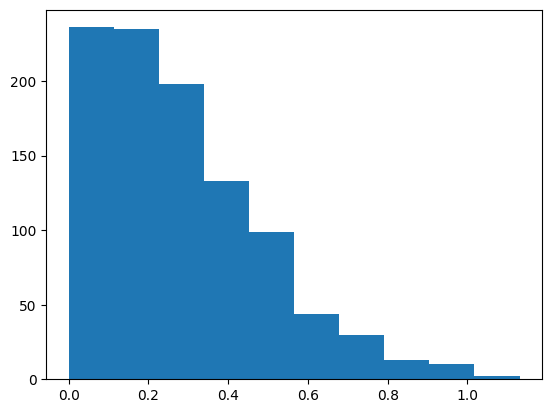

In [9]:
plt.hist(first_1000["distance_score_sentiment"])

In [10]:
for ind, row in first_1000[first_1000["distance_score_sentiment"]>0.8].iterrows():
    print(row["body"])
    print(row["score"], row["sentiment"])
    #print(preprocess_and_predict(row["body"]))

If something like this could make someone support ISIS, then they were barbaric savages already. Lost causes. 
0.5 -0.31390972932179767
Babies born to older mothers have significantly higher chances of defects.
Should we ban old mothers?

Edit: I've now made 3 posts seemingly defending incest, that is going to look creepy as fuck.
0.638 -0.2887326677640279
You were pointing logical fallacies in OPs comment. I think under these circumstances you can be forgiven for being *pro-*incest, ya fucken *weirdo*.      
      
Oop...shit...sorry mate.       
I've got no idea where *that* came from ¯\\_(ツ)_/¯      
      
      

0.562 -0.27547810475031537
fuck who you want to as long as they can consent.  
0.688 -0.1742507815361023
That is a much more eloquent way of saying what I was trying to say.  Thanks!
-0.667 0.3104175329208374
If you want to take away my rights because of something I was born with and didn’t choose, you are my fucking enemy.
0.681 -0.3142242431640625
When I was a kid - gra

(array([  6.,  17.,  64., 115., 156., 116.,  58.,  23.,  14.,   3.]),
 array([-0.625 , -0.4799, -0.3348, -0.1897, -0.0446,  0.1005,  0.2456,
         0.3907,  0.5358,  0.6809,  0.826 ]),
 <BarContainer object of 10 artists>)

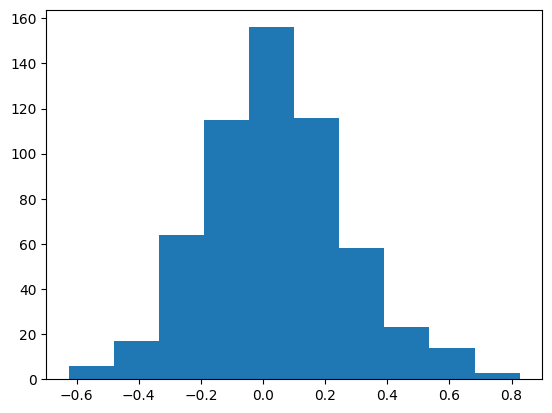

In [11]:
just_negative1000=first_1000[first_1000["sentiment"]<0]
plt.hist(just_negative1000["score"])

(array([ 1.,  7., 11., 13., 11., 11.,  6.,  2.,  3.,  1.]),
 array([-0.792 , -0.6711, -0.5502, -0.4293, -0.3084, -0.1875, -0.0666,
         0.0543,  0.1752,  0.2961,  0.417 ]),
 <BarContainer object of 10 artists>)

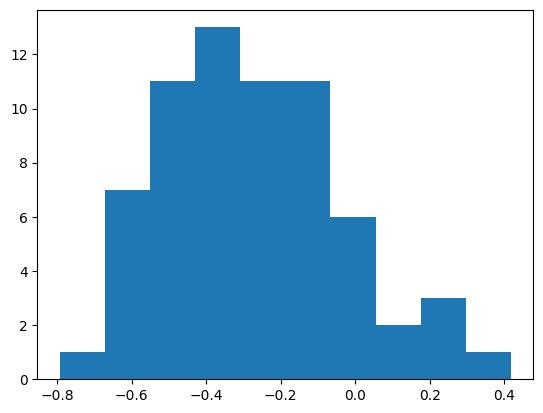

In [12]:
just_positive1000=first_1000[first_1000["sentiment"]>0]
plt.hist(just_positive1000["score"])

In [13]:
pos_path = os.path.join(os.pardir, 'raw_data', 'comments_positive.csv')
neg_path = os.path.join(os.pardir, 'raw_data', 'comments_negative.csv')
pos_df=pd.read_csv(pos_path)
contr_pos=pos_df[pos_df["controversiality"]>0]

In [14]:
pos_df.columns

Index(['id', 'parent_id', 'subreddit_id', 'link_id', 'text', 'score', 'ups',
       'author', 'controversiality', 'parent_link_id', 'parent_text',
       'parent_score', 'parent_ups', 'parent_author',
       'parent_controversiality'],
      dtype='object')

In [17]:
sent_scorings=[]
counter=0
for ind, row in pos_df.iterrows():
    counter=counter +1
    if counter>1000:
        break
    try:
        print(row['text'])
        print(preprocess_and_predict2(row['text']))
        sent_scorings.append(preprocess_and_predict2(row['text']))
    except:
        pass

This isn't Twitter: try to comment on the article, and not your current activities.
-0.17503496011098227
Well, it is exactly what it sounds like. It's a shoebox, or at least once was, and whenever I masturbate I cum into it. I've had it for two or three years now I think, so it has a fair amount of cum. It smells atrocious, and I tried to burn it once. When I lit it on fire, it was too damp due to the cum that it simply sizzled and didn't manage to actually lite up. Turns out burning cum smells awful, so I had to spray it with a deodorant body spray just to get the old smell of burnt cum away. It also has some drenched papers stuck to it. That's pretty much it.

Because people were asking, [my greatest shame.](http://imgur.com/a/UD5Lo#ZLkrA)

EDIT 2: A lot of people are asking me, why? Well, I'm apparently a rather disturbed individual. But, it just kind of happened, bought new shoes and needed someplace to cum, used the box. It just escalated from there, kept using it each time, telli

(array([175., 130.,  58.,   0., 441.,   0.,   3.,  37.,  57.,  87.]),
 array([-0.31870912, -0.25401502, -0.18932093, -0.12462683, -0.05993274,
         0.00476136,  0.06945545,  0.13414955,  0.19884364,  0.26353774,
         0.32823183]),
 <BarContainer object of 10 artists>)

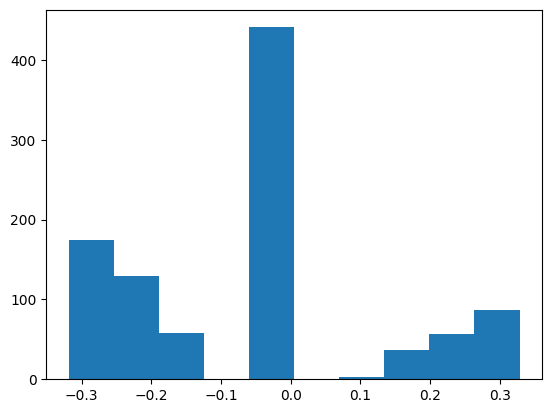

In [16]:
plt.hist(sent_scorings)